## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
projectdir = "/home/jovyan/work/MED_Fall"
workdir = "/home/jovyan/work"

In [3]:
import os

os.environ["PYTHONPATH"]

'/home/jovyan/work/MED_Fall/'

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from utils.utility_functions import listdir_nohidden_sorted as lsdir
from utils.utility_functions import load_images, show_images

In [ ]:
tf.config.list_physical_devices("GPU")

## Setup the dataframe for keras flow_from_dataframe pipeline

In [7]:
extracted_frames_path = (
    "/home/jovyan/work/MED_Fall/vision/vision_dataset/extracted_frames"
)

In [8]:
ground_truth_path = "/home/jovyan/work/MED_Fall/vision/vision_dataset/ground_truth_new"

In [9]:
# load all csv files containing frame names and corresponding labels
dfs = []
for file in lsdir(ground_truth_path):
    df = pd.read_csv(file)
    dfs.append(df)
dataset = pd.concat(dfs, ignore_index=True)
dataset = dataset.iloc[:, 2:]
dataset["frame_name"] += ".jpg"

In [10]:
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004.jpg
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


### Visualize some frames from the dataset

In [11]:
# removector actor repositioning frames
on_air_ds = dataset.loc[dataset["ar_labels"] == "on_air"]
on_air_ds

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206.jpg
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207.jpg
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208.jpg
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209.jpg
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210.jpg
...,...,...,...,...
1182213,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533.jpg
1182214,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534.jpg
1182215,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535.jpg
1182216,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536.jpg


In [12]:
# select 10 random samples for each class (adl, falling, lying_down)
rand_samples = on_air_ds.groupby("macro_labels").sample(n=10)
rand_samples.head()

,micro_labels,macro_labels,ar_labels,frame_name
223797,stand_up_from_sit,adl,on_air,actor_1_walk2_full_ph_cam_2_3897.jpg
741364,sit_up_from_lying,adl,on_air,actor_2_walk_armour_obj_cam_6_0124.jpg
864391,stand_up_from_sit,adl,on_air,actor_3_bed_full_ph_cam_7_2911.jpg
384381,walking,adl,on_air,actor_1_walk_shoe_full_ph_cam_3_1041.jpg
990091,walking,adl,on_air,actor_3_walk_stick_full_ph_cam_3_5611.jpg


In [13]:
# produce images to plot titles concatenating the frame name with the corresponding label
titles = rand_samples["frame_name"] + " -- " + rand_samples["macro_labels"]
titles

223797          actor_1_walk2_full_ph_cam_2_3897.jpg -- adl
741364        actor_2_walk_armour_obj_cam_6_0124.jpg -- adl
864391            actor_3_bed_full_ph_cam_7_2911.jpg -- adl
384381      actor_1_walk_shoe_full_ph_cam_3_1041.jpg -- adl
990091     actor_3_walk_stick_full_ph_cam_3_5611.jpg -- adl
470226             actor_2_bed_armour_cam_1_2346.jpg -- adl
471130             actor_2_bed_armour_cam_1_3250.jpg -- adl
56634             actor_1_bed_full_ph_cam_6_1794.jpg -- adl
489375             actor_2_bed_armour_cam_7_0255.jpg -- adl
482753             actor_2_bed_armour_cam_5_0713.jpg -- adl
595641       actor_2_chair_armour_cam_3_0681.jpg -- falling
433963                actor_2_bed_cam_2_4243.jpg -- falling
829757                actor_3_bed_cam_3_1277.jpg -- falling
749715       actor_2_walk_full_ph_cam_1_2955.jpg -- falling
292231               actor_1_walk_cam_5_2491.jpg -- falling
187059           actor_1_chair_ph_cam_1_3939.jpg -- falling
472316         actor_2_bed_armour_cam_2_

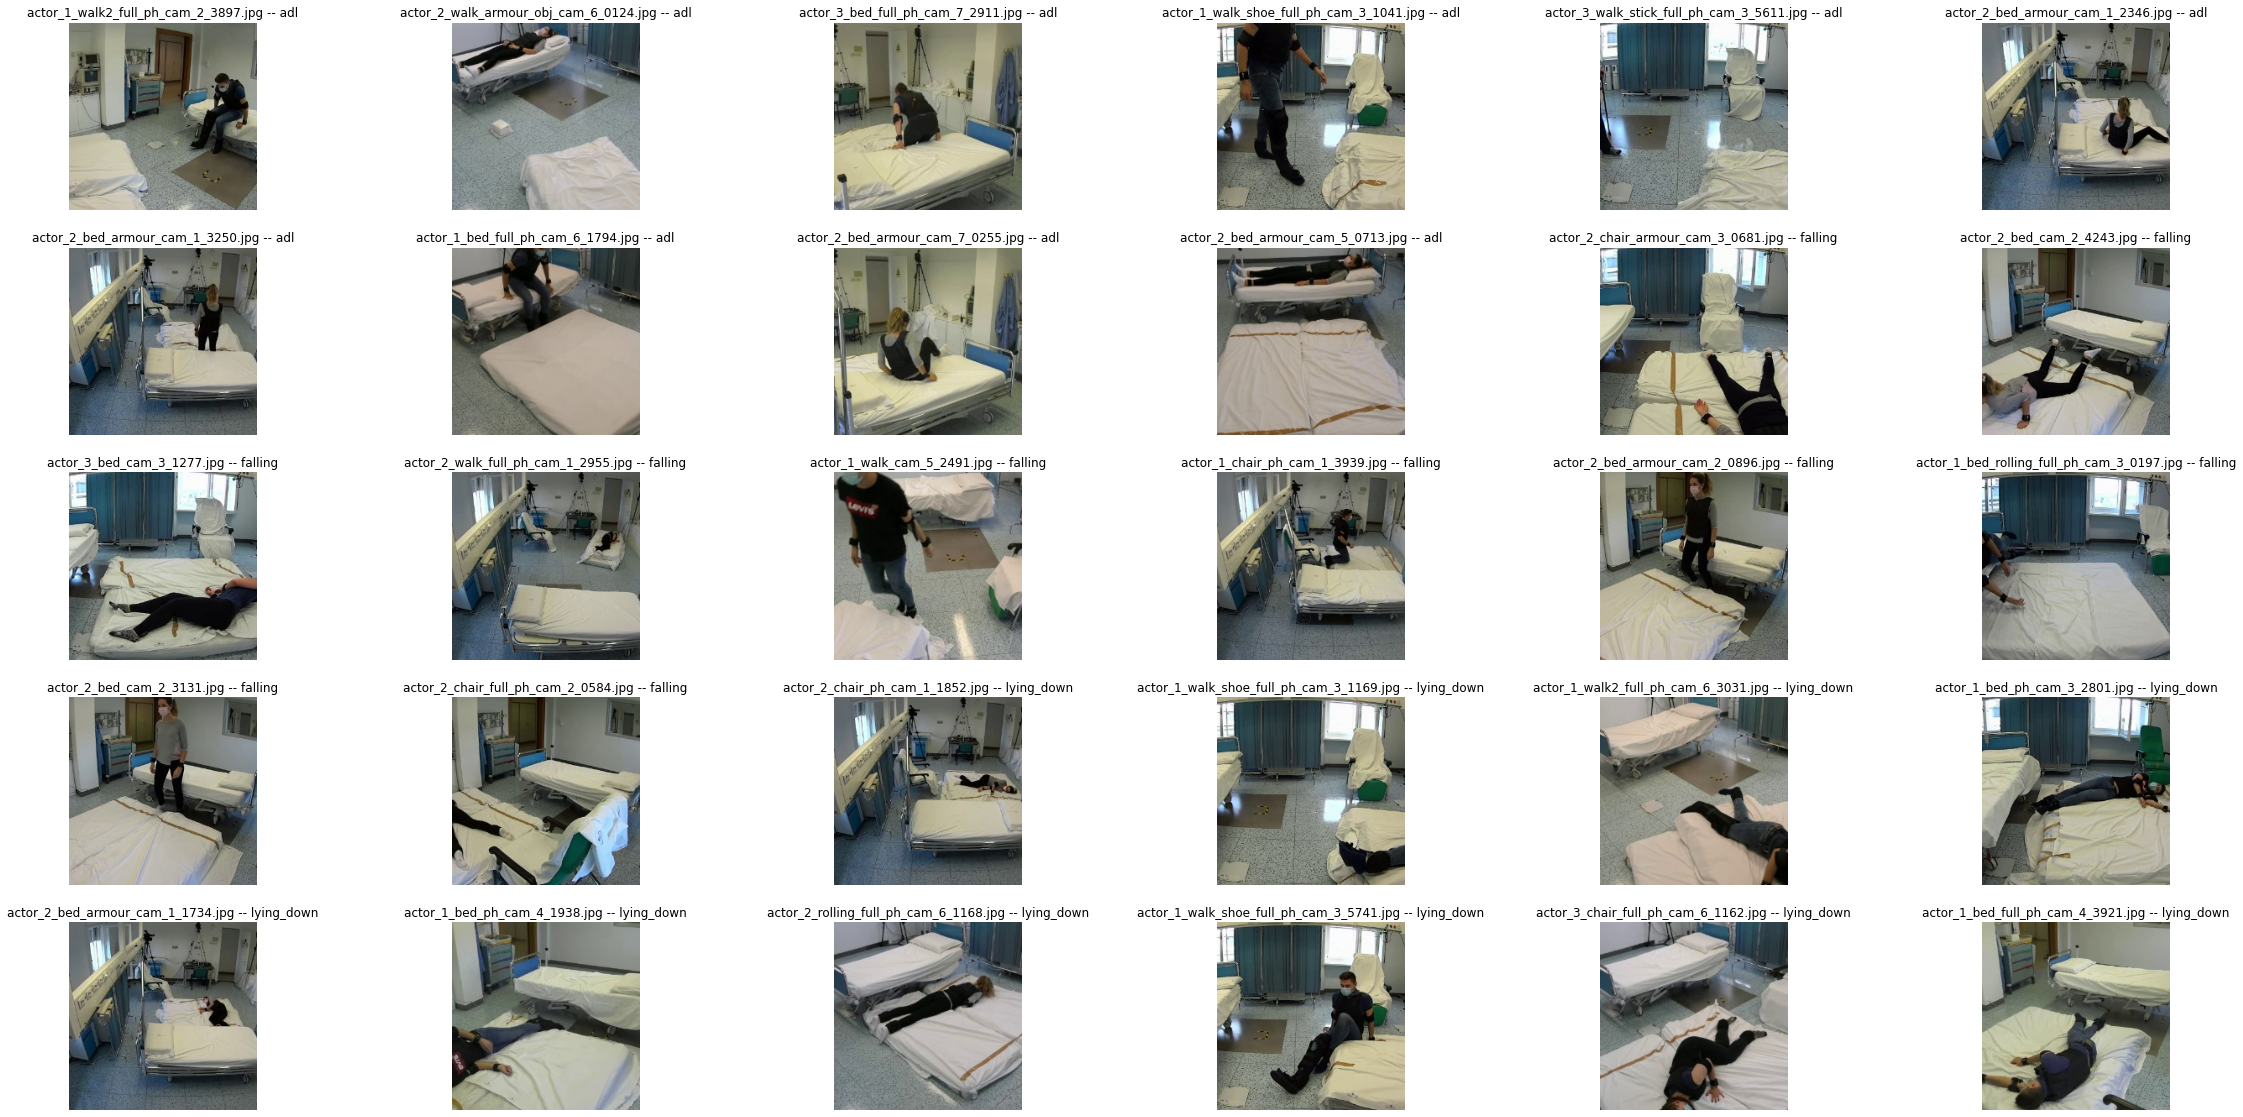

In [14]:
# load the images in a numpy array
images = load_images(extracted_frames_path, rand_samples["frame_name"])

# plot the loaded images with corresponding frame name and label
show_images(
    images,
    rows=5,
    figsize=(40, 20),
    titles=titles,
)

## Subsample dataset choosing Actor 4 as fine tuning data

In [15]:
# select only actor 4 frames
actor_4_dataset = dataset[dataset["frame_name"].str.contains("actor_4")]

In [16]:
actor_4_dataset.reset_index(drop=True, inplace=True)
actor_4_dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0000.jpg
1,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0001.jpg
2,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0002.jpg
3,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0003.jpg
4,lie_still,lying_down,actor_repositioning,actor_4_bed_cam_1_0004.jpg
...,...,...,...,...
168415,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615.jpg
168416,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616.jpg
168417,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617.jpg
168418,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618.jpg


In [17]:
# select only frames where the actor is performing a sequence (is not repositioning)
actor_4_dataset = actor_4_dataset.loc[actor_4_dataset["ar_labels"] == "on_air"]
actor_4_dataset

,micro_labels,macro_labels,ar_labels,frame_name
126,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0126.jpg
127,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0127.jpg
128,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0128.jpg
129,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0129.jpg
130,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0130.jpg
...,...,...,...,...
168333,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533.jpg
168334,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534.jpg
168335,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535.jpg
168336,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536.jpg


### Show some actor 4 frames

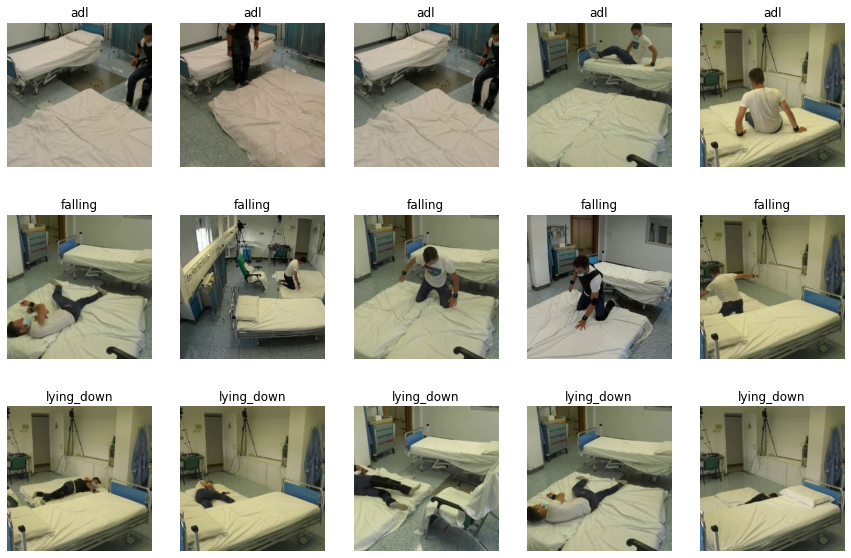

In [19]:
# select 5 random actor 4 frames per class
some_actor_4_samples = actor_4_dataset.groupby("macro_labels").sample(n=5)

# load frames
images = load_images(extracted_frames_path, some_actor_4_samples["frame_name"])

# show frames
show_images(images, titles=some_actor_4_samples["macro_labels"])

In [20]:
# train-val random split with 90-10 % distribution
train_set = actor_4_dataset.sample(frac=0.9, random_state=2)
val_set = actor_4_dataset.drop(train_set.index)

print("train_set shape: ", train_set.shape, "val_set shape: ", val_set.shape)

train_set shape:  (35431, 4) val_set shape:  (3937, 4)


In [21]:
# count samples per class in the actor 4 dataset
train_set["macro_labels"].value_counts()

adl           23140
falling       11677
lying_down      614
Name: macro_labels, dtype: int64

### Undersample the actor 4 train set adl class to balance at least adl and falling number of samples

In [22]:
# select adl sampels from train set
adl_train = train_set.loc[train_set["macro_labels"] == "adl"]
adl_train.reset_index(drop=True, inplace=True)
adl_train

,micro_labels,macro_labels,ar_labels,frame_name
0,stand_up_from_sit,adl,on_air,actor_4_chair_cam_3_1280.jpg
1,rolling_bed,adl,on_air,actor_4_bed_full_ph_cam_3_6665.jpg
2,rolling_bed,adl,on_air,actor_4_bed_full_ph_cam_7_6653.jpg
3,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_7_0827.jpg
4,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_5_2467.jpg
...,...,...,...,...
23135,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_7_0718.jpg
23136,sit_up_from_lying,adl,on_air,actor_4_bed_cam_1_0594.jpg
23137,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_4_3192.jpg
23138,stand_up_from_sit,adl,on_air,actor_4_chair_full_ph_cam_3_1521.jpg


In [26]:
# count the number of lying_down samples
n_fall_samples = train_set["macro_labels"].value_counts()[1]
print("number of fall samples:", n_fall_samples)

number of fall samples: 11677


In [28]:
# sample n_fall_samples randomly from adl class
adl_train_under = adl_train.sample(n=n_fall_samples, random_state=2)
adl_train_under

,micro_labels,macro_labels,ar_labels,frame_name
15847,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_2_3172.jpg
10831,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_1_1795.jpg
21927,stand_up_from_sit,adl,on_air,actor_4_chair_cam_4_1319.jpg
2059,stand_up_from_sit,adl,on_air,actor_4_chair_full_ph_cam_1_4425.jpg
11744,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_5_0807.jpg
...,...,...,...,...
9346,stand_up_from_sit,adl,on_air,actor_4_chair_cam_7_1280.jpg
1622,stand_up_from_sit,adl,on_air,actor_4_bed_cam_1_1225.jpg
22070,sit_up_from_lying,adl,on_air,actor_4_bed_cam_5_2274.jpg
2725,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_4_0724.jpg


In [29]:
# make a copy of the training set
train_set_copy = train_set.copy()

# select all samples except the ones with class
train_set_copy = train_set_copy[train_set_copy["macro_labels"] != "adl"]
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
158570,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_5_4010.jpg
72172,lie_down_on_the_floor,lying_down,on_air,actor_4_bed_full_ph_cam_5_5812.jpg
156754,fall_lateral,falling,on_air,actor_4_chair_full_ph_cam_5_2194.jpg
111137,crouched_still,falling,on_air,actor_4_bed_full_ph_knee_cam_7_1217.jpg
18422,lie_down_on_the_floor,lying_down,on_air,actor_4_bed_cam_7_1862.jpg
...,...,...,...,...
146953,fall_lateral,falling,on_air,actor_4_chair_full_ph_cam_3_1633.jpg
17235,fall_frontal,falling,on_air,actor_4_bed_cam_7_0675.jpg
142899,fall_lateral,falling,on_air,actor_4_chair_full_ph_cam_2_2199.jpg
17262,fall_frontal,falling,on_air,actor_4_bed_cam_7_0702.jpg


In [31]:
# count the number of samples to make sure they are the same as before
train_set_copy["macro_labels"].value_counts()

falling       11677
lying_down      614
Name: macro_labels, dtype: int64

In [32]:
# concat the fall and lying_down samples with the undersampled adl set
train_set_copy = pd.concat([train_set_copy, adl_train_under], axis=0)
train_set_copy

,micro_labels,macro_labels,ar_labels,frame_name
158570,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_5_4010.jpg
72172,lie_down_on_the_floor,lying_down,on_air,actor_4_bed_full_ph_cam_5_5812.jpg
156754,fall_lateral,falling,on_air,actor_4_chair_full_ph_cam_5_2194.jpg
111137,crouched_still,falling,on_air,actor_4_bed_full_ph_knee_cam_7_1217.jpg
18422,lie_down_on_the_floor,lying_down,on_air,actor_4_bed_cam_7_1862.jpg
...,...,...,...,...
9346,stand_up_from_sit,adl,on_air,actor_4_chair_cam_7_1280.jpg
1622,stand_up_from_sit,adl,on_air,actor_4_bed_cam_1_1225.jpg
22070,sit_up_from_lying,adl,on_air,actor_4_bed_cam_5_2274.jpg
2725,sit_up_from_lying,adl,on_air,actor_4_bed_full_ph_cam_4_0724.jpg


In [33]:
# count the values of the balanced train set
train_set_copy["macro_labels"].value_counts()

falling       11677
adl           11677
lying_down      614
Name: macro_labels, dtype: int64

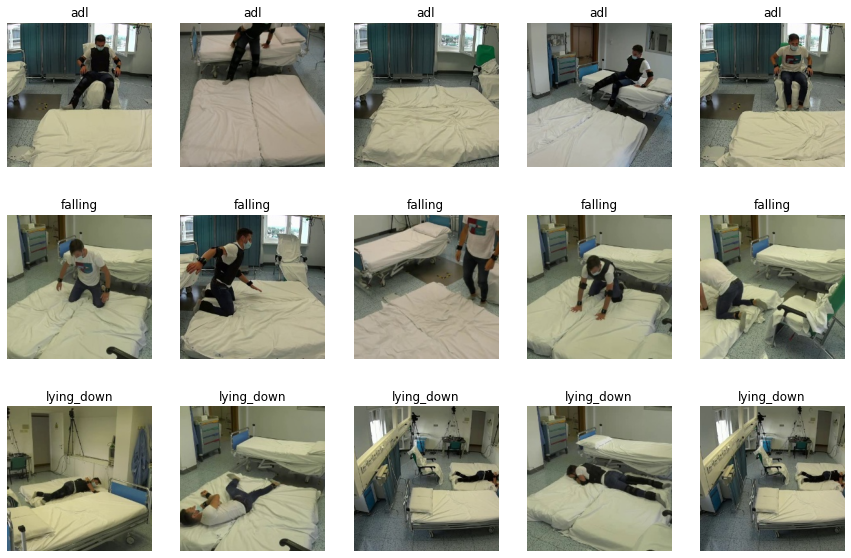

In [34]:
# show some frames from the balanced train set
some_samples = train_set_copy.groupby("macro_labels").sample(n=5)
images = load_images(extracted_frames_path, some_samples["frame_name"])

show_images(images, titles=some_samples["macro_labels"])

## Fine tune VGG16 on Actor 4

### Instantiate Training and Validation Generators

In [34]:
#istantiate train ImageDataGenerator and define image augmentations.
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

#flow from dataframe loads frames from provided df, which is Actor 4 subset after balancing.
train_datagen = train_generator.flow_from_dataframe(
    train_set_copy,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=2,
)

Found 23968 validated image filenames belonging to 3 classes.


In [35]:
#define validation ImageDataGenerator. No data augmentation is performed. The images are just rescaled to (0,1)
val_generator = ImageDataGenerator(rescale=1.0 / 255)

val_datagen = val_generator.flow_from_dataframe(
    val_set,
    directory=extracted_frames_path,
    x_col="frame_name",
    y_col="macro_labels",
    target_size=(224, 224),
    color_mode="rgb",
    classes=["adl", "lying_down", "falling"],
    class_mode="categorical",
    batch_size=64,
    shuffle=False,
    seed=2,
)

Found 3937 validated image filenames belonging to 3 classes.


In [36]:
# print samples per class identified from train generator
print(pd.Series(train_datagen.classes).value_counts())
print(train_datagen.class_indices)

1    11677
0    11677
2      614
dtype: int64
{'adl': 0, 'falling': 1, 'lying_down': 2}


In [37]:
# print samples per class identified from val generator
print(pd.Series(val_datagen.classes).value_counts())
print(val_datagen.class_indices)

0    2564
1    1315
2      58
dtype: int64
{'adl': 0, 'falling': 1, 'lying_down': 2}


### Download pre-trained VGG16

In [38]:
# define image size 
IMG_SIZE = (224, 224, 3)

In [39]:
# Download VGG16 pre-trained on ImageNet
feature_extractor = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMG_SIZE,
    pooling="avg",
)

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2022-08-18 15:06:46.249352: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 15:06:46.682560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21353 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


### Freeze all layers except last convolutional block

In [40]:
# freeze all layers except last five
for layer in feature_extractor.layers[:-9]:
    layer.trainable = False

for i, layer in enumerate(feature_extractor.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d True


### Add top layer to fine tune

In [41]:
# adding two dense layers (512 and 256 units). Final dense layer with 3 neurons.
x = feature_extractor.output
x = Flatten()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=3, activation="softmax")(x)

transfer_model = Model(inputs=feature_extractor.input, outputs=x)

transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Compile the model and define callbacks

In [42]:
# compile the model and keep track of each class's recall
transfer_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(class_id=0),
        tf.keras.metrics.Recall(class_id=1),
        tf.keras.metrics.Recall(class_id=2),
    ],
)

In [43]:
# checkpoint the model every epoch if val_loss improves
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{projectdir}/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

In [44]:
callbacks = [
    model_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),  # reduces optimizer's lr if val_loss stops decreasing
    tf.keras.callbacks.EarlyStopping(patience=5,
                                     verbose=1),   # early stops the training if val_loss increases for 5 epochs straight
]

### Train the model

In [ ]:
# fit the model for 100 epochs
history = transfer_model.fit(
    train_datagen, validation_data=val_datagen, epochs=100, callbacks=callbacks
)

### Evaluate the model

In [6]:
# load best checkpoint
best_model = tf.keras.models.load_model(
    f"{projectdir}/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5"
)

2022-08-19 09:14:21.184193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 09:14:21.609451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21353 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [56]:
# evaluate the model on the val set
best_model.evaluate(val_datagen)

62/62 [==============================] - 7s 114ms/step - loss: 0.0238 - accuracy: 0.9931 - recall: 0.9934 - recall_1: 0.9932 - recall_2: 0.9828


[0.02383919060230255,
 0.9931420087814331,
 0.9933697581291199,
 0.9931558966636658,
 0.982758641242981]

In [ ]:
# plot the accuracies
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# plot the losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [57]:
y_preds_logits = best_model.predict(val_datagen)

In [58]:
y_preds = np.argmax(y_preds_logits, axis=1)

In [59]:
# print classification report
print(
    classification_report(
        y_true=val_datagen.classes,
        y_pred=y_preds,
        target_names=list(val_datagen.class_indices.keys()),
    )
)

              precision    recall  f1-score   support

         adl       1.00      0.99      1.00      2564
     falling       0.99      0.99      0.99      1315
  lying_down       0.97      0.98      0.97        58

    accuracy                           0.99      3937
   macro avg       0.98      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [60]:
pd.Series(train_datagen.classes).value_counts()

1    11677
0    11677
2      614
dtype: int64

In [66]:
#%cp ~/work/MED_Fall/vision/model_checkpoints/resample/vgg_top_fine_tuned_best_epoch_undersample.h5 ~/work/persistent/

In [ ]:
load_images()

## Save Features Extractor

In [7]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# detach the previously added dense layers
feature_extractor = Sequential(best_model.layers[:-5])
feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [9]:
# freeze again al layers
for layer in feature_extractor.layers:
    layer.trainable = False
for layer in feature_extractor.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [74]:
# save the feature extractor
feature_extractor.save(f"{projectdir}/vision/models/vgg_feature_extractor.h5")

In [ ]:
# predict a fake image to check that output size is the correct number of features.
pred_test = feature_extractor.predict(np.ones(shape=(1, 224, 224, 3)))
print(pred_test.shape)

(1, 512)
